In [ ]:
from sunpy.map import Map
from sunpy.net import Fido, attrs as a
from astropy.time import Time
import astropy.units as u

In [ ]:
tr = a.Time('2023-10-20T00:00:00', '2023-10-20T00:01:00')
tr

<sunpy.net.attrs.Time(2023-10-20 00:00:00.000, 2023-10-20 00:01:00.000)>

In [ ]:
a.jsoc.Series('hmi.m_720s')

<sunpy.net.jsoc.attrs.Series(hmi.m_720s: magnetograms with a cadence of 720 seconds.) object at
0x7f1bd2bb3640>

In [ ]:
result = Fido.search(tr, a.jsoc.Series('hmi.m_720s'), a.jsoc.Notify('mgjeon@khu.ac.kr'))
result

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str23,str7,str12,float64,int64
2023.10.20_00:00:00_TAI,SDO/HMI,HMI_COMBINED,6173.0,2276


In [ ]:
files = Fido.fetch(result)
files

2025-03-09 12:59:09 - drms - INFO: Export request pending. [id=JSOC_20250309_000291, status=2]
2025-03-09 12:59:09 - drms - INFO: Waiting for 0 seconds...
2025-03-09 12:59:10 - sunpy - INFO: 1 URLs found for download. Full request totaling 14MB


INFO: 1 URLs found for download. Full request totaling 14MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

<parfive.results.Results object>
['/home/usr/sunpy/data/hmi.m_720s.20231020_000000_TAI.3.magnetogram.fits']

In [ ]:
smap = Map(files[0])

In [ ]:
smap.rsun_obs

<Quantity 963.53875732 arcsec>

In [ ]:
smap.scale[0]

<Quantity 0.50403702 arcsec / pix>

In [ ]:
r_obs_pix = smap.rsun_obs / smap.scale[0]
r_obs_pix

<Quantity 1911.64282256 pix>

In [ ]:
import numpy as np

In [ ]:
def get_mask(smap, radius=None):
  Y, X = np.ogrid[:smap.data.shape[0], :smap.data.shape[1]]
  xc, yc = smap.wcs.world_to_pixel(smap.center)
  dist = np.sqrt((X-xc)**2 + (Y-yc)**2)
  r_obs_pix = smap.rsun_obs / smap.scale[0]
  radius = r_obs_pix.value if radius is None else radius
  mask = dist <= r_obs_pix.value
  return mask

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

In [ ]:
from astropy.coordinates import SkyCoord

In [ ]:
resolution = 1024
padding_factor = 0.28

s_map = smap

r_obs_pix = s_map.rsun_obs / s_map.scale[0]
print(f"Solar radius : {r_obs_pix.value:.2f} pix => {(resolution / 2) / (1 + padding_factor):.2f} pix = 1 solar radii")
print(f"Resolution/2 : {s_map.data.shape[0]/2:.2f} pix => {resolution/2:.2f} pix = {1+padding_factor:.2f} solar radii")

r_obs_pix = (1 + padding_factor) * r_obs_pix
scale_factor = resolution / (2 * r_obs_pix.value)
s_map = Map(np.nan_to_num(s_map.data).astype(np.float32), s_map.meta)
s_map = s_map.rotate(recenter=True, scale=scale_factor, missing=0, order=4)
s_map.meta['r_sun'] = s_map.rsun_obs.value / s_map.meta['cdelt1']

mask = get_mask(s_map)
data = s_map.data * mask.astype(int)
data[data == 0] = np.nan
s_map = Map(data, s_map.meta)
s_map

arcs_frame = (resolution / 2) * s_map.scale[0].value  # half width in arcseconds
# print(f"Resolution/2 : {arcs_frame:.2f} arcsec")
s_map = s_map.submap(
    bottom_left=SkyCoord(-arcs_frame*u.arcsec, -arcs_frame*u.arcsec, frame=s_map.coordinate_frame),
    top_right=SkyCoord(arcs_frame*u.arcsec, arcs_frame*u.arcsec, frame=s_map.coordinate_frame)
)
pad_x = s_map.data.shape[0] - resolution
pad_y = s_map.data.shape[1] - resolution
s_map = s_map.submap(
    bottom_left=[pad_x // 2, pad_y // 2] * u.pix,
    top_right=[pad_x // 2 + resolution - 1, pad_y // 2 + resolution - 1] * u.pix
)
if s_map.data.shape[0] < resolution or s_map.data.shape[1] < resolution:
    data = s_map.data
    new_data = np.zeros((resolution, resolution))
    padding_x = (resolution - data.shape[0]) // 2
    padding_y = (resolution - data.shape[1]) // 2
    new_data[padding_x:padding_x + data.shape[0], padding_y:padding_y + data.shape[1]] = data
    s_map = Map(new_data, s_map.meta)
data = s_map.data
data[data == 0] = np.nan
s_map = Map(data, s_map.meta)

Solar radius : 1911.64 pix => 400.00 pix = 1 solar radii
Resolution/2 : 2048.00 pix => 512.00 pix = 1.28 solar radii


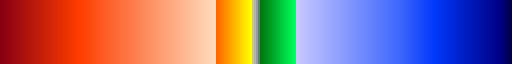

In [ ]:
cmap = plt.get_cmap('hmimag')
cmap.set_bad('black')
cmap

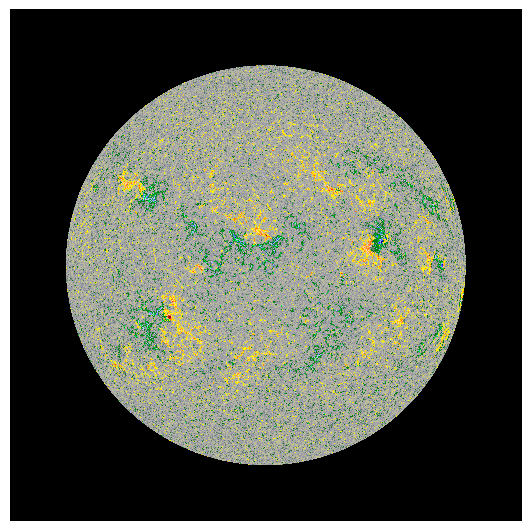

In [ ]:
fig = plt.figure(figsize=(5.12, 5.12), frameon=False)
ax = plt.axes([0, 0, 1, 1], projection=s_map)
s_map.plot(axes=ax, cmap=cmap, norm=simple_norm(s_map.data, vmin=-1000, vmax=1000))
ax.set_axis_off()
ax.set_title('')
fig.savefig('hmi.png', dpi=200)
# plt.close()

In [ ]:
now = Time.now()
now

<Time object: scale='utc' format='datetime' value=2025-03-09 03:59:12.774630>

In [ ]:
tr = a.Time(now-1*u.hour, now)
tr

<sunpy.net.attrs.Time(2025-03-09 02:59:12.775, 2025-03-09 03:59:12.775)>

In [ ]:
result = Fido.search(tr, a.Instrument.aia, a.Wavelength(171*u.AA))
result

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Type,Size
,,,,Angstrom,,,,,Mibyte
Time,Time,str3,str3,float64[2],str8,str9,str6,str8,float64
2025-03-09 03:00:00.000,2025-03-09 03:00:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:03:00.000,2025-03-09 03:03:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:06:00.000,2025-03-09 03:06:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:09:00.000,2025-03-09 03:09:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:12:00.000,2025-03-09 03:12:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:15:00.000,2025-03-09 03:15:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:18:00.000,2025-03-09 03:18:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562
2025-03-09 03:21:00.000,2025-03-09 03:21:00.000,SDO,AIA,171.0 .. 171.0,SDAC_AIA,intensity,NARROW,FULLDISK,4.01562


In [ ]:
files = Fido.fetch(result[0][-1])
files

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

AIA20250309_034200_0171.fits:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

<parfive.results.Results object>
['/home/usr/sunpy/data/AIA20250309_034200_0171.fits']

In [ ]:
smap = Map(files[0])

In [ ]:
resolution = 1024
padding_factor = 0.28

s_map = smap

r_obs_pix = s_map.rsun_obs / s_map.scale[0]
print(f"Solar radius : {r_obs_pix.value:.2f} pix => {(resolution / 2) / (1 + padding_factor):.2f} pix = 1 solar radii")
print(f"Resolution/2 : {s_map.data.shape[0]/2:.2f} pix => {resolution/2:.2f} pix = {1+padding_factor:.2f} solar radii")
r_obs_pix = (1 + padding_factor) * r_obs_pix
scale_factor = resolution / (2 * r_obs_pix.value)
s_map = Map(np.nan_to_num(s_map.data).astype(np.float32), s_map.meta)
s_map = s_map.rotate(recenter=True, scale=scale_factor, missing=0, order=4)

arcs_frame = (resolution / 2) * s_map.scale[0].value  # half width in arcseconds
# print(f"Resolution/2 : {arcs_frame:.2f} arcsec")
s_map = s_map.submap(
    bottom_left=SkyCoord(-arcs_frame*u.arcsec, -arcs_frame*u.arcsec, frame=s_map.coordinate_frame),
    top_right=SkyCoord(arcs_frame*u.arcsec, arcs_frame*u.arcsec, frame=s_map.coordinate_frame)
)
pad_x = s_map.data.shape[0] - resolution
pad_y = s_map.data.shape[1] - resolution
s_map = s_map.submap(
    bottom_left=[pad_x // 2, pad_y // 2] * u.pix,
    top_right=[pad_x // 2 + resolution - 1, pad_y // 2 + resolution - 1] * u.pix
)
if s_map.data.shape[0] < resolution or s_map.data.shape[1] < resolution:
    data = s_map.data
    new_data = np.zeros((resolution, resolution))
    padding_x = (resolution - data.shape[0]) // 2
    padding_y = (resolution - data.shape[1]) // 2
    new_data[padding_x:padding_x + data.shape[0], padding_y:padding_y + data.shape[1]] = data
    s_map = Map(new_data, s_map.meta)

Solar radius : 402.67 pix => 400.00 pix = 1 solar radii
Resolution/2 : 512.00 pix => 512.00 pix = 1.28 solar radii


In [ ]:
fig = plt.figure(figsize=(5.12, 5.12), frameon=False)
ax = plt.axes([0, 0, 1, 1], projection=smap)
smap.plot(axes=ax, clip_interval=(1, 99.9)*u.percent)
ax.set_axis_off()
ax.set_title('')
fig.savefig('171.png', dpi=200)
plt.close()